<a href="https://colab.research.google.com/github/rsrikrishnan27/DS/blob/main/Customer%20Clustering%20and%20Lifetime%20Value/RFM_CLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# Loading necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

Link to Dataset: https://archive.ics.uci.edu/ml/datasets/online+retail

## Data Cleaninig and EDA

In [71]:
online = pd.read_csv('OnlineRetail.csv',encoding= 'unicode_escape')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom



- InvoiceNo: Invoice number. Nominal, a 6-digit integral number
uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric. 
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 
- UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal, the name of the country where each customer resides.

In [72]:
online = online.dropna()

In [73]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [74]:
online.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [75]:
#Adding columns: invoice_value,Year, Month, Day and Date
online['invoice_value'] = online['Quantity']*online['UnitPrice']
online['Year'] = pd.DatetimeIndex(online['InvoiceDate']).year
online['Month'] = pd.DatetimeIndex(online['InvoiceDate']).month
online['Day'] =  pd.DatetimeIndex(online['InvoiceDate']).day
online['Date'] = pd.DatetimeIndex(online['InvoiceDate']).date

In [76]:
online['CustomerID'] = online['CustomerID'].astype(str)
online['InvoiceDate'] = online['InvoiceDate'].astype('datetime64[ns]')

# Keep the last two words as the type of products
a = online['Description'].str.split()
online['Type'] = a.apply(lambda x: ' '.join(x[-2:]))

In [77]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,invoice_value,Year,Month,Day,Date,Type
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,1,12,2010-01-12,T-LIGHT HOLDER
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,1,12,2010-01-12,METAL LANTERN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,1,12,2010-01-12,COAT HANGER
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,1,12,2010-01-12,WATER BOTTLE
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,1,12,2010-01-12,WHITE HEART.


In [78]:
#Monthly revenue is sum up all 'invoice_value' in a month
monthly = online.groupby(['Year', 'Month'])['invoice_value'].sum()
monthly = monthly.to_frame()
monthly = monthly.set_index(pd.Index(monthly.index))

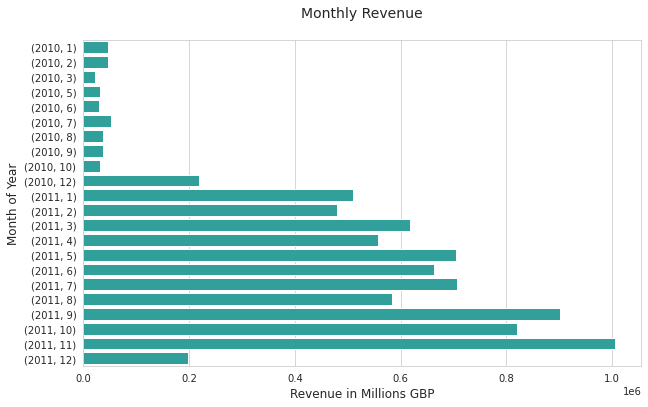

In [79]:
sns.set_style('whitegrid')
h = sns.barplot(x = 'invoice_value', y = monthly.index, data = monthly, color = 'lightseagreen')
h.figure.set_size_inches(10, 6)
h.set_xlabel('Revenue in Millions GBP', size = 12)
h.set_ylabel('Month of Year', size = 12)
h.set_title('Monthly Revenue', size = 14, y = 1.05)
plt.show()

In [80]:
#Revenue by countries is sum up of all 'invoice_value' for each country.
revenue_per_country = online.groupby(['Country'])['invoice_value'].sum().sort_values(ascending=False)
revenue_per_country = revenue_per_country.to_frame()
revenue_per_country.head()

,invoice_value
Country,
United Kingdom,6767873.394
Netherlands,284661.540
EIRE,250285.220
Germany,221698.210
France,196712.840


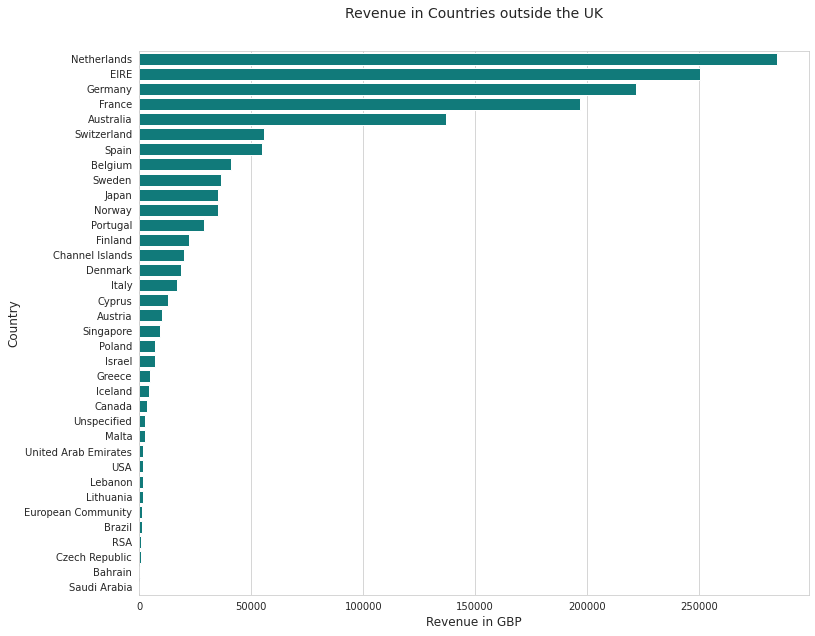

In [81]:
#Excuding the UK from the dataset
country = revenue_per_country[revenue_per_country.index != 'United Kingdom']

#Plotting 

g = sns.barplot(x = 'invoice_value', y = country.index , data = country, color = 'darkcyan')
g.figure.set_size_inches(12, 10)
g.set_xlabel('Revenue in GBP', size = 12)
g.set_ylabel('Country', size = 12)
g.set_title('Revenue in Countries outside the UK', size = 14, y = 1.05)
plt.show()

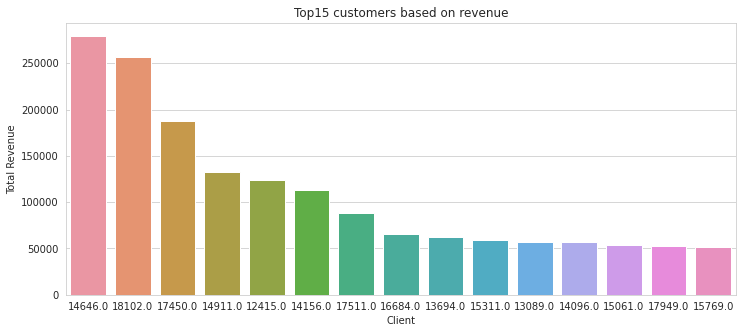

In [82]:
# Top15 customers
Rev_Coustomer=online.groupby('CustomerID')['invoice_value'].sum().sort_values(ascending=False).reset_index()[:15]
plt.figure(figsize=(12,5))
sns.barplot(x='CustomerID', y='invoice_value', data=Rev_Coustomer)
plt.title("Top15 customers based on revenue")
plt.xlabel('Client')
plt.ylabel('Total Revenue')
plt.show()

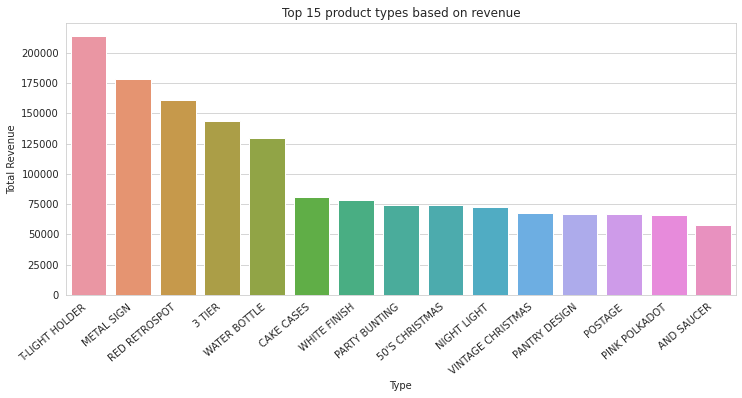

In [83]:
# Top15 product types

Rev_Country = online.groupby('Type')['invoice_value'].sum().sort_values(ascending=False).reset_index()[:15]
plt.figure(figsize=(12,5))
sns.barplot(x='Type', y='invoice_value', data=Rev_Country)
plt.xticks(rotation=40,ha='right')
plt.title("Top 15 product types based on revenue")
plt.xlabel('Type')
plt.ylabel('Total Revenue')
plt.show()

## Preprocessing data for clustering

We are going to peform clustering techniques on RFM metrics. 

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [84]:
# Monetary
rfm_m = online.groupby('CustomerID')['invoice_value'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,invoice_value
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [85]:
# Frequency 

rfm_f = online.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [86]:
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,invoice_value,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [87]:
# Recency 

max_date = max(online['InvoiceDate'])
max_date

Timestamp('2011-12-10 17:19:00')

In [88]:
online['Diff'] = max_date - online['InvoiceDate']
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,invoice_value,Year,Month,Day,Date,Type,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,1,12,2010-01-12,T-LIGHT HOLDER,697 days 08:53:00
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,1,12,2010-01-12,METAL LANTERN,697 days 08:53:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,1,12,2010-01-12,COAT HANGER,697 days 08:53:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,1,12,2010-01-12,WATER BOTTLE,697 days 08:53:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,1,12,2010-01-12,WHITE HEART.,697 days 08:53:00


In [89]:
rfm_r = online.groupby('CustomerID')['Diff'].min()
rfm_r = rfm_r.reset_index()
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r.head()

,CustomerID,Diff
0,12346.0,326
1,12347.0,40
2,12348.0,76
3,12349.0,19
4,12350.0,311


In [90]:
rfm = pd.merge(rfm, rfm_r, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'M', 'F', 'R']
rfm.head()

,CustomerID,M,F,R
0,12346.0,0.00,2,326
1,12347.0,4310.00,182,40
2,12348.0,1797.24,31,76
3,12349.0,1757.55,73,19
4,12350.0,334.40,17,311


## Outlier Analysis

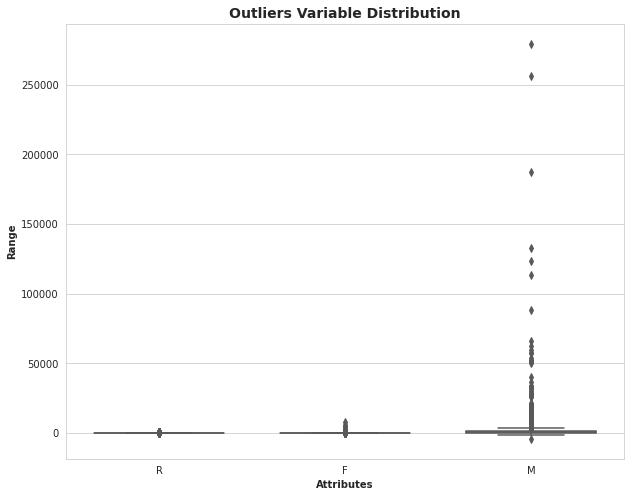

In [91]:
# Plotting R, F and M to check for outliers

attributes = ['R','F','M']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.show()

In [92]:
# Removing statistical outliers for R, F and M


Q1 = rfm.M.quantile(0.05)
Q3 = rfm.M.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.M >= Q1 - 1.5*IQR) & (rfm.M <= Q3 + 1.5*IQR)]


Q1 = rfm.R.quantile(0.05)
Q3 = rfm.R.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.R >= Q1 - 1.5*IQR) & (rfm.R <= Q3 + 1.5*IQR)]


Q1 = rfm.F.quantile(0.05)
Q3 = rfm.F.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.F >= Q1 - 1.5*IQR) & (rfm.F <= Q3 + 1.5*IQR)]

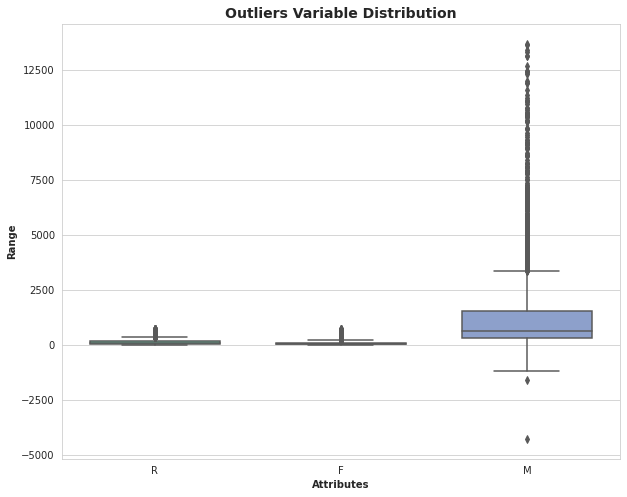

In [93]:
# Plot after removing outliers

attributes = ['R','F','M']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.show()

## Data Scaling 

Data is rescaled using Standardisation where mean is 0 and sigma is 1

In [94]:
# Rescaling the attributes

rfm_df = rfm[['R', 'F', 'M']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [95]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['R', 'F', 'M']
rfm_df_scaled.head()

,R,F,M
0,1.954651,-0.752888,-0.723738
1,-0.546982,1.042467,1.731617
2,-0.232091,-0.463636,0.300128
3,-0.730668,-0.044720,0.277517
4,1.823447,-0.603275,-0.533235


## Building K-means clustering model 

In [96]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [97]:
kmeans.labels_

array([0, 3, 2, ..., 2, 2, 2], dtype=int32)

### Finding optimum k 

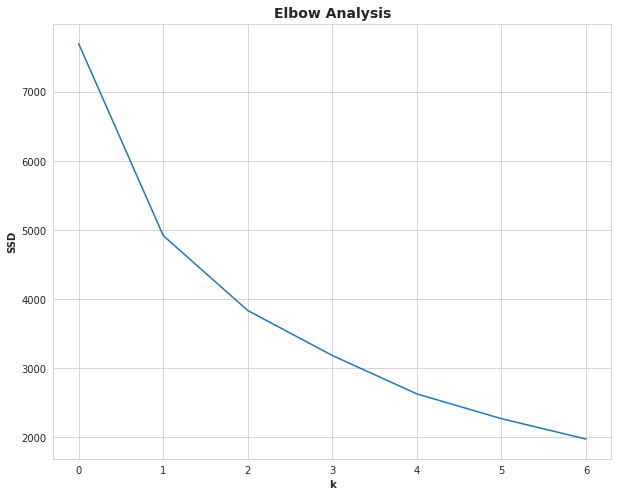

In [98]:
# Elbow method 

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.title("Elbow Analysis", fontsize = 14, fontweight = 'bold')
plt.ylabel("SSD", fontweight = 'bold')
plt.xlabel("k", fontweight = 'bold')
plt.show()

In [99]:
# Silhouette Method

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5501362051961678
For n_clusters=3, the silhouette score is 0.4700476001746889
For n_clusters=4, the silhouette score is 0.4458975279324812
For n_clusters=5, the silhouette score is 0.45308835475429177
For n_clusters=6, the silhouette score is 0.44631480498620496
For n_clusters=7, the silhouette score is 0.4326812448761373
For n_clusters=8, the silhouette score is 0.3946097339063518


Taking K = 3 as optimal 

In [100]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [101]:
# Assigning labels to the RFM data 

rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,M,F,R,Cluster_Id
0,12346.0,0.00,2,326,1
1,12347.0,4310.00,182,40,0
2,12348.0,1797.24,31,76,2
3,12349.0,1757.55,73,19,2
4,12350.0,334.40,17,311,1


### Cluster Analysis with R, F and M 

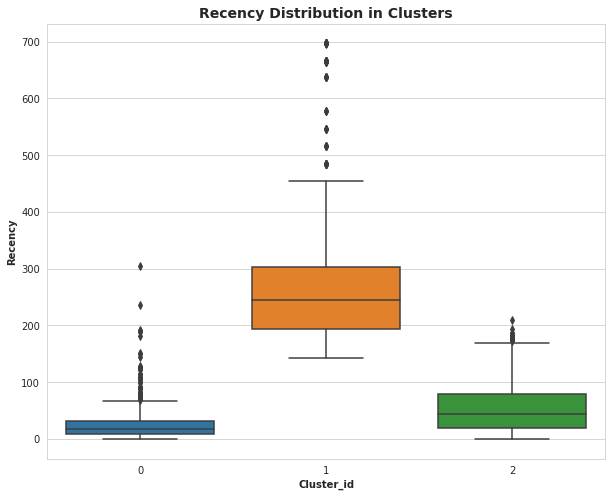

In [102]:
# Recency 

sns.boxplot(x='Cluster_Id', y='R', data=rfm)
plt.title("Recency Distribution in Clusters", fontsize = 14, fontweight = 'bold')
plt.ylabel("Recency", fontweight = 'bold')
plt.xlabel("Cluster_id", fontweight = 'bold')
plt.show()

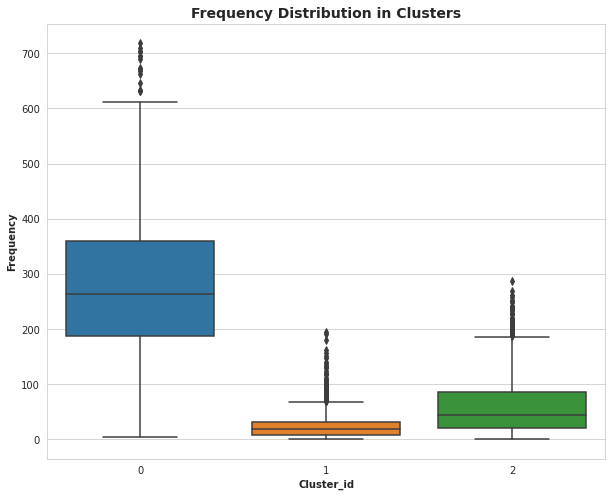

In [103]:
# Frequency 

sns.boxplot(x='Cluster_Id', y='F', data=rfm)
plt.title("Frequency Distribution in Clusters", fontsize = 14, fontweight = 'bold')
plt.ylabel("Frequency", fontweight = 'bold')
plt.xlabel("Cluster_id", fontweight = 'bold')
plt.show()

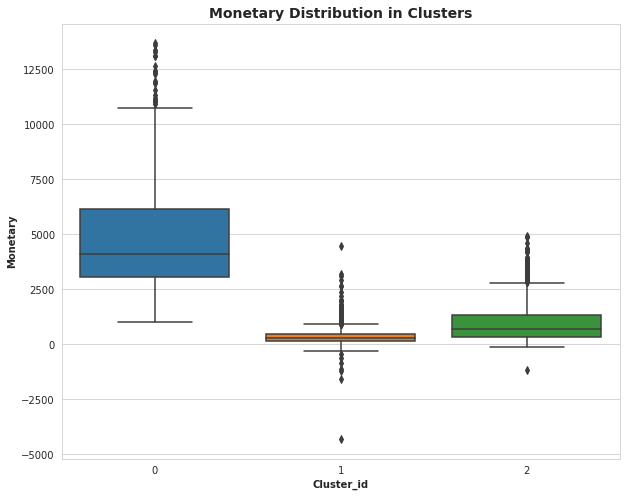

In [104]:
# Monetary

sns.boxplot(x='Cluster_Id', y='M', data=rfm)
plt.title("Monetary Distribution in Clusters", fontsize = 14, fontweight = 'bold')
plt.ylabel("Monetary", fontweight = 'bold')
plt.xlabel("Cluster_id", fontweight = 'bold')
plt.show()

## Insights from k-means clustering: 

- Customers belonging to cluster id 0 are frequent buyers with high amount of transation 

- Customers belonging to cluster id 1 are not frequent and recent buyers. The maybe one-time buyers 

## Building Hierarchical Clustering model

In [105]:
import sys
sys.setrecursionlimit(10000)

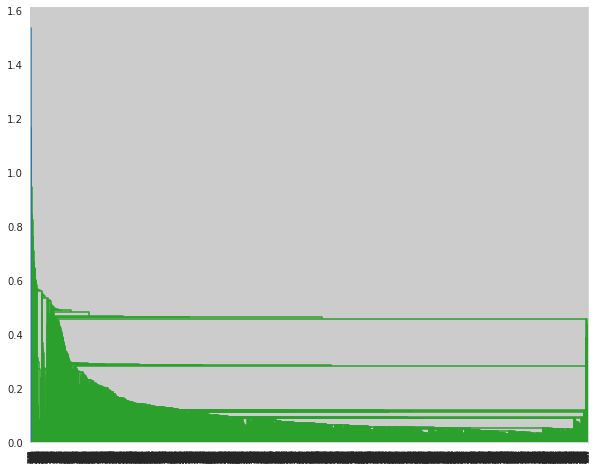

In [106]:
# Single Linkage 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

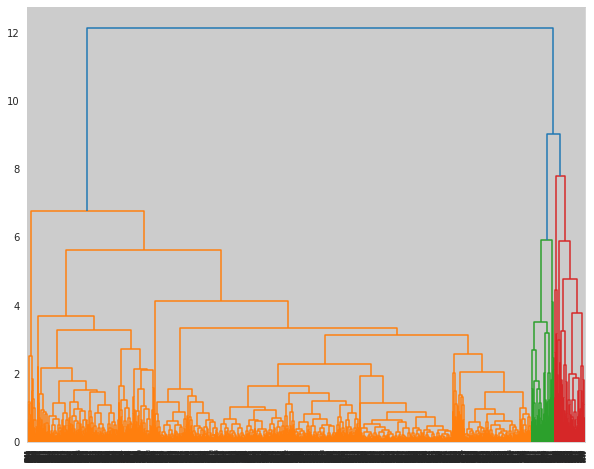

In [107]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

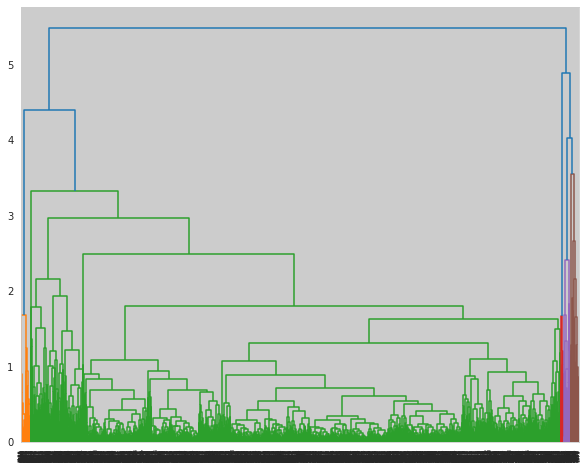

In [108]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()


In [109]:
# Cutting the dendogram at k = 3 

cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [110]:
rfm['Cluster_id_hier'] = cluster_labels
rfm.head()

,CustomerID,M,F,R,Cluster_Id,Cluster_id_hier
0,12346.0,0.00,2,326,1,0
1,12347.0,4310.00,182,40,0,0
2,12348.0,1797.24,31,76,2,0
3,12349.0,1757.55,73,19,2,0
4,12350.0,334.40,17,311,1,0


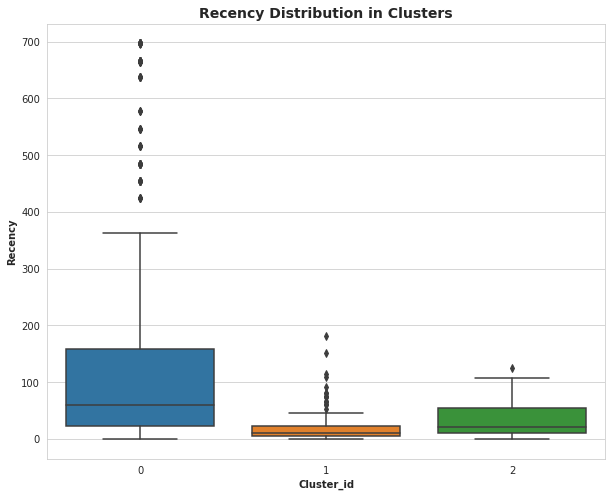

In [111]:
# Recency 

sns.boxplot(x='Cluster_id_hier', y='R', data=rfm)
plt.title("Recency Distribution in Clusters", fontsize = 14, fontweight = 'bold')
plt.ylabel("Recency", fontweight = 'bold')
plt.xlabel("Cluster_id", fontweight = 'bold')
plt.show()

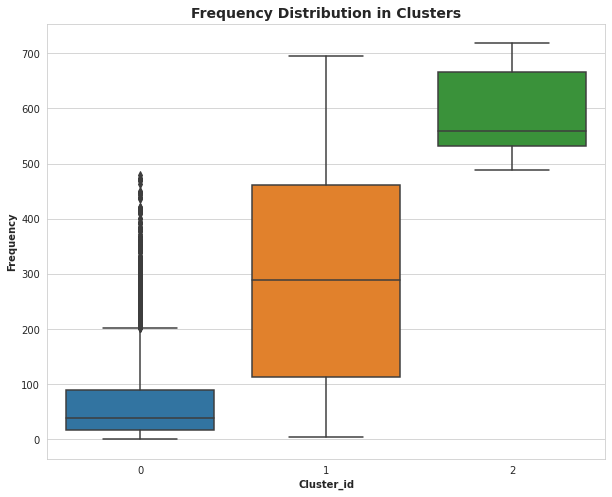

In [112]:
# Frequency 

sns.boxplot(x='Cluster_id_hier', y='F', data=rfm)
plt.title("Frequency Distribution in Clusters", fontsize = 14, fontweight = 'bold')
plt.ylabel("Frequency", fontweight = 'bold')
plt.xlabel("Cluster_id", fontweight = 'bold')
plt.show()

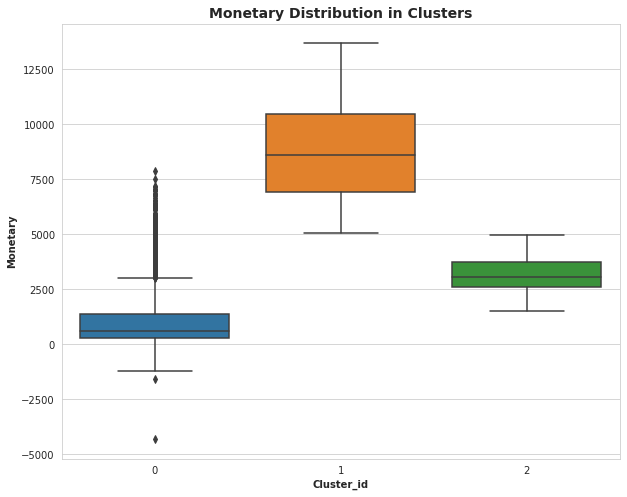

In [113]:
# Monetary

sns.boxplot(x='Cluster_id_hier', y='M', data=rfm)
plt.title("Monetary Distribution in Clusters", fontsize = 14, fontweight = 'bold')
plt.ylabel("Monetary", fontweight = 'bold')
plt.xlabel("Cluster_id", fontweight = 'bold')
plt.show()

## Insights from Hierarchical Clustering: 

- Customers belonging to cluster id 0 are not frequent and recent buyers and contribute the least to revenue. 

- Customers belonging to cluster id 2 are frequent and recent buyers 

- Customers from cluster id 1 give maximum revenue



## Customer Life-Time Value 

We are using the following formula to calculate CLTV: 

CLTV = Customer Value * Average Customer lifespan 

Customer Value = Average purchase value * Average Frequency rate

In [119]:
# CLTV Calculation 

#Calculate average revenue per invoice 
revenue_per_purchase = online.groupby(['InvoiceNo'])['invoice_value'].mean().mean()

#Calculate average number unique invoices per customer per month
freg = online.groupby(['CustomerID', 'Month'])['InvoiceNo'].nunique().mean()

#Define customer life-spand to 24 months
lifespand_months = 24

#Calculate granular CLV
cltv_granular = revenue_per_purchase*freg*lifespand_months

# Print granular CLV value
print('The Customer Life-Time Value(CLTV) is {:.1f} USD'.format(cltv_granular))

The Customer Life-Time Value(CLTV) is 1342.2 USD
